# Experiment Run

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [1]:
%load_ext autoreload
%autoreload 2

import os
from time import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white")

import vis
import softclustering as sc
import socceraction.spadl as spadl

### Load data

In [2]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")
    actions = sc.consolidate(actions)
    actions = sc.add_noise(actions)
    actions = sc.remove_outliers(actions, True)
    actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
    actions["cos_angle"] = np.cos(actions["angle"])
    actions["sin_angle"] = np.sin(actions["angle"])



64it [00:00, 222.42it/s]


Remove 560 out of 128484 datapoints.


## Experiment

There are 10 action types that are to be clustered using Gaussian mixture distribution. Some of the actions have not and end location, thus are not relevant for this research because we cannot compute their direction. Also the action "shot_penalty" always has the same start location, so no need to cluster them.

In [3]:
# select actions type to run location soft clustering
# shot penalty has always the same starting point
no_dir_action_types = set(actions[actions["angle"] == 0.0]["type_name"])
action_types = set(actions["type_name"]) - no_dir_action_types - {"shot_penalty"}
action_types

{'clearance',
 'corner',
 'cross',
 'dribble',
 'freekick',
 'goalkick',
 'keeper_action',
 'pass',
 'shot',
 'throw_in'}

### Location mixture: Number of clusters calibration

We look for the optimal number of location clusters for each action type based on both the Bayesian Information Criterion and a modified Calinski–Harabasz index for soft clustering.
$$CH = \frac{BC/(K-1)}{WC/(N-K)},$$
where between-cluster distance ($BC$) and within-cluster distance ($WC$) are defined as:
$$BC = \min_{\bar{\eta}}\sum_{j=1}^K \pi_j D_{\phi}[\eta_j : \bar{\eta}], \quad WC = -\sum_{i=1}^N\sum_{j=1}^K \ln (f(x_i|\theta_j)\cdot \pi_j) \, P(C_j|x_i).$$

In [4]:
rows = []
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type)  #& (actions["team_id"] == 771)
    loc_data = actions[mask][["start_x", "start_y"]]

    for model in ["classic"]:
        print(f" {model}", end="")
        for init_method in ["k-means"]:
            for K in range(2, 16):
                print(f" {K} clus.,", end="")
                gauss_clusters = [sc.MultivariateGaussian() for _ in range(K)]

                start = time()
                loc_model = sc.MixtureModel(gauss_clusters,
                                            init=init_method)
                loc_model.fit(loc_data, verbose=False, case=model)
                end = time() - start

                rows.append({
                    "action_type": action_type,
                    "model": model,
                    "initialization": init_method,
                    "cluster_nbr": K,
                    "ch_score": round(sc.kl_ch_score(loc_data, loc_model), 5),
                    "bic_score": round(sc.bic_score_mixture(loc_data, loc_model), 0),
                    "aic_score": round(sc.aic_score_mixture(loc_data, loc_model), 0),
                    "running_time": round(end, 3)
                })

loc_scores = pd.DataFrame(rows)


Processing freekick:
 classic 2 clus., 3 clus., 4 clus., 5 clus., 6 clus., 7 clus., 8 clus., 9 clus., 10 clus., 11 clus., 12 clus., 13 clus., 14 clus., 15 clus.,
Processing dribble:
 classic 2 clus., 3 clus., 4 clus., 5 clus., 6 clus., 7 clus., 8 clus., 9 clus., 10 clus., 11 clus., 12 clus., 13 clus., 14 clus., 15 clus.,
Processing corner:
 classic 2 clus., 3 clus., 4 clus., 5 clus., 6 clus., 7 clus., 8 clus., 9 clus., 10 clus., 11 clus., 12 clus., 13 clus., 14 clus., 15 clus.,
Processing pass:
 classic 2 clus., 3 clus., 4 clus., 5 clus., 6 clus., 7 clus., 8 clus., 9 clus., 10 clus., 11 clus., 12 clus., 13 clus., 14 clus., 15 clus.,
Processing cross:
 classic 2 clus., 3 clus., 4 clus., 5 clus., 6 clus., 7 clus., 8 clus., 9 clus., 10 clus., 11 clus., 12 clus., 13 clus., 14 clus., 15 clus.,
Processing throw_in:
 classic 2 clus., 3 clus., 4 clus., 5 clus., 6 clus., 7 clus., 8 clus., 9 clus., 10 clus., 11 clus., 12 clus., 13 clus., 14 clus., 15 clus.,
Processing goalkick:
 classic 2 clus.

In [5]:
df = loc_scores.sort_values(by=["action_type", "ch_score"], ascending=[True, False])

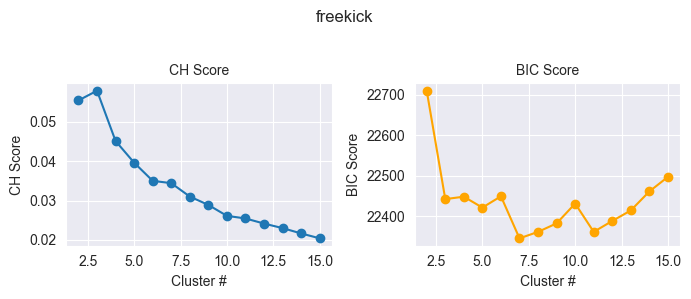

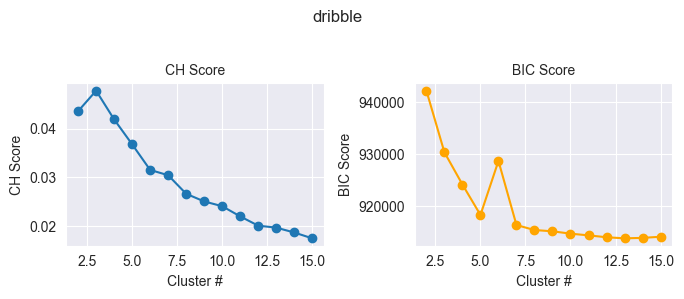

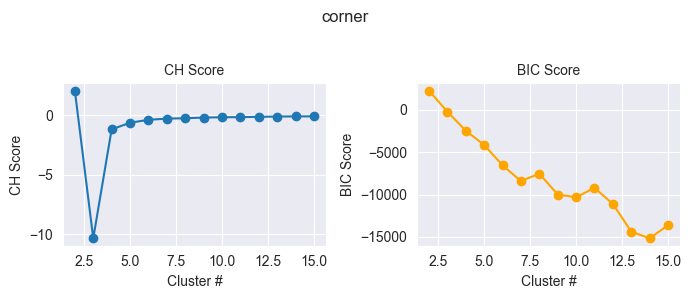

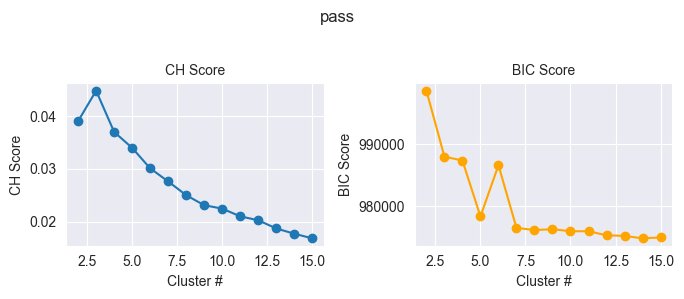

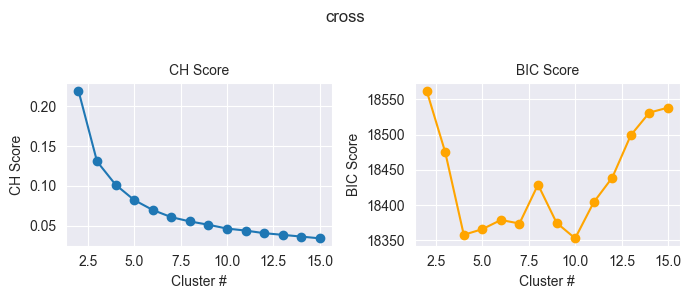

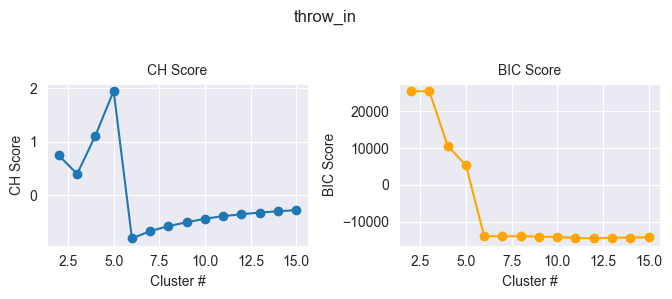

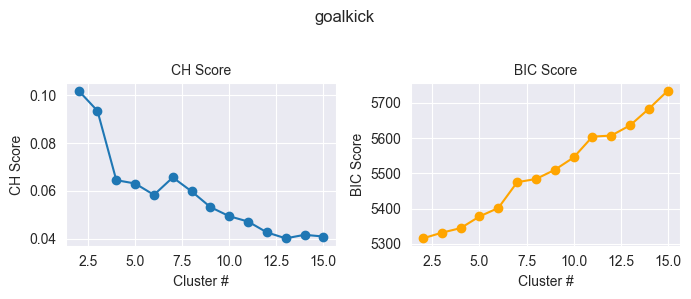

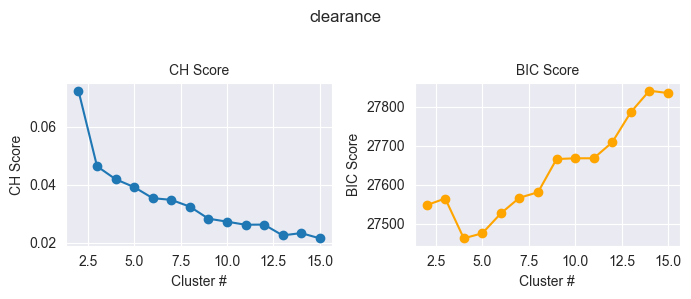

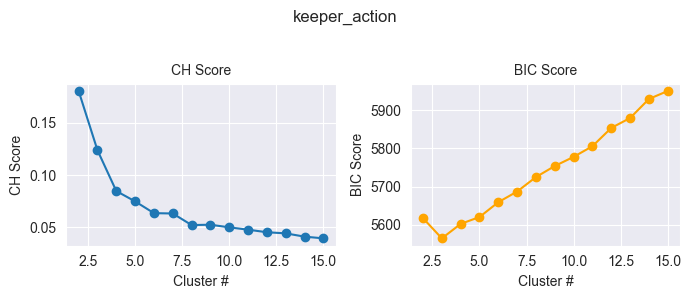

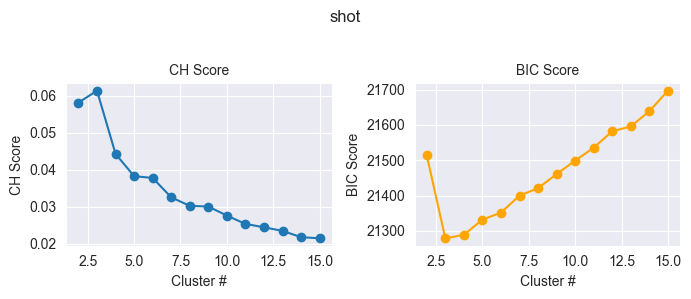

In [6]:
# Filter CH scores
loc_scores_filtered = loc_scores[(loc_scores["model"] == "classic")
                                 & (loc_scores["initialization"] == "k-means")
    # & (loc_scores["ch_score"] <= 2)
    # & (loc_scores["ch_score"] > 0)
                                 ]

# Loop through each action_type and make a (1,2) plot per type
for action_type in action_types:
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))
    fig.suptitle(f"{action_type}", fontsize=12)

    # CH Score subplot
    ch_data = loc_scores_filtered[loc_scores_filtered["action_type"] == action_type]
    axes[0].plot(ch_data["cluster_nbr"], ch_data["ch_score"], marker="o")
    axes[0].set_title("CH Score", fontsize=10)
    axes[0].set_xlabel("Cluster #")
    axes[0].set_ylabel("CH Score")

    # BIC Score subplot
    bic_data = loc_scores[(loc_scores["action_type"] == action_type)]
    axes[1].plot(bic_data["cluster_nbr"], bic_data["bic_score"], marker="o", color="orange")
    axes[1].set_title("BIC Score", fontsize=10)
    axes[1].set_xlabel("Cluster #")
    axes[1].set_ylabel("BIC Score")

    plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))
    plt.show()

In [7]:
optimal_loc_K = {
    f"{action_type}": group.loc[group["bic_score"].idxmin(), "cluster_nbr"]
    for action_type, group in loc_scores_filtered.groupby("action_type")
}
optimal_loc_K

{'clearance': 4,
 'corner': 14,
 'cross': 10,
 'dribble': 13,
 'freekick': 7,
 'goalkick': 2,
 'keeper_action': 3,
 'pass': 14,
 'shot': 3,
 'throw_in': 12}

In [8]:
optimal_loc_K = {
    'clearance': 4,  # check
    'cross': 4,  # manually added
    'dribble': 4,  # check
    'freekick': 3,  # check
    'goalkick': 2,  # manually added
    'keeper_action': 3,  # manually added
    'pass': 5,  # manually added
    'shot': 3,  # check
    'throw_in': 6,  # manually added
    'corner': 2  # manually added
}

In [9]:
loc_models = {}
for action_type in action_types:
    print(f"Processing {action_type}...")
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]]
    loc_K = optimal_loc_K[action_type]
    gauss_clusters = [sc.MultivariateGaussian() for _ in range(loc_K)]
    loc_model = sc.MixtureModel(gauss_clusters,
                                init='k-means')
    _ = loc_model.fit(loc_data, case="bregman")
    loc_models[action_type] = loc_model

Processing freekick...
Processing dribble...
Processing corner...
Processing pass...
Processing cross...
Processing throw_in...
Processing goalkick...
Processing clearance...
Processing keeper_action...
Processing shot...


In [10]:
print(loc_models["pass"])

MixtureModel(n_components=5)
  ├─ (0) w=0.070  MultivariateGaussian(d=2, mean=[16.894 32.902], cov=[[61.42  -5.358], [ -5.358 218.513]])
  ├─ (1) w=0.085  MultivariateGaussian(d=2, mean=[57.052  3.478], cov=[[414.451  -1.422], [-1.422  2.944]])
  ├─ (2) w=0.387  MultivariateGaussian(d=2, mean=[52.892 20.481], cov=[[403.286 -32.353], [-32.353  84.767]])
  ├─ (3) w=0.074  MultivariateGaussian(d=2, mean=[56.572 64.831], cov=[[421.282  -0.026], [-0.026  2.003]])
  └─ (4) w=0.384  MultivariateGaussian(d=2, mean=[53.102 49.038], cov=[[409.518  25.421], [25.421 73.67 ]])


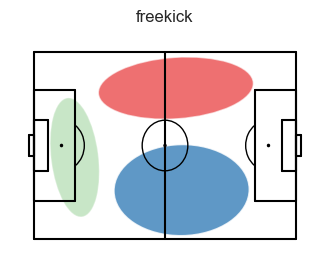

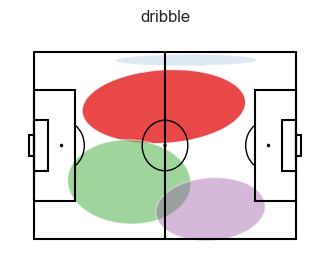

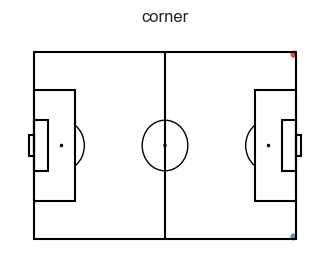

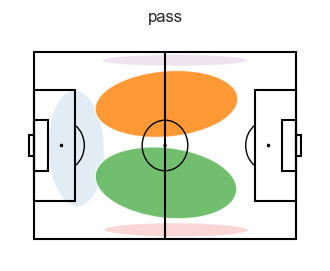

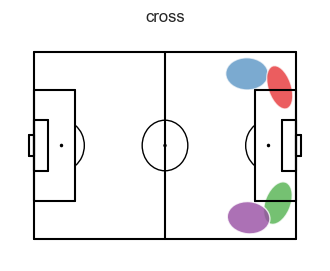

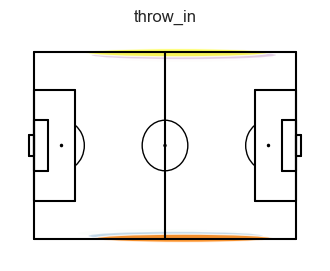

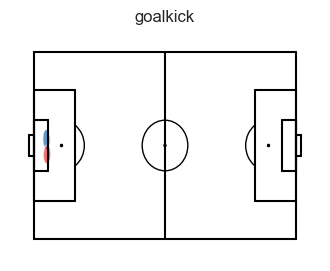

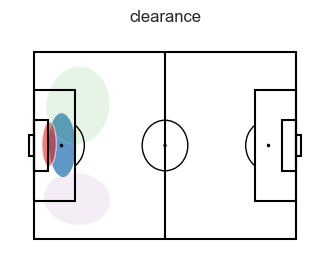

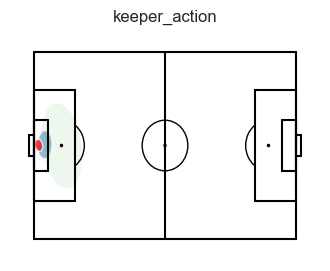

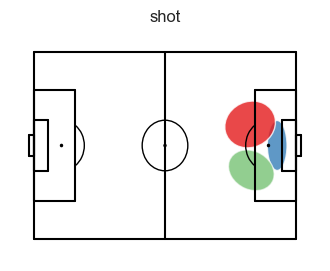

In [11]:
for action_type in action_types:
    vis.show_location_model(loc_models[action_type], figsize=4, title=action_type)

### Two-Layer Model Experiment

Using the selected number of location clusters, and a fixed amount of direction cluster for each first-layer component.

In [12]:
rows = []
two_layer_models = {}
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]]
    dir_data = actions[mask][["cos_angle", "sin_angle"]]
    K_loc = optimal_loc_K[action_type]
    K_dir = [3 for _ in range(K_loc)]

    for case in ["bregman", "classic", "approximation"]:
        print(f"   Approach: {case}")
        for init in ["k-means++", "k-means", "random", "random_from_data"]:
            print(f"      Init: {init}")
            loc_mixture = sc.MixtureModel(
                [sc.MultivariateGaussian() for _ in range(K_loc)],
                init=init
            )
            dir_mixtures = [sc.MixtureModel(
                [sc.VonMises() for _ in range(K_dir[j])],
                init=init
            )
                for j in range(K_loc)]
            model = sc.TwoLayerScheme(loc_mixture,
                                      dir_mixtures)
            start = time()
            model.fit(loc_data, dir_data,
                      case=case,
                      tol=1e-2,
                      verbose=False)
            end = time() - start

            two_layer_models[f"{action_type}_{case}_{init}"] = model
            rows.append({
                "action_type": action_type,
                "model": case,
                "init": init,
                "bic_score": round(model.bic_score(loc_data, dir_data), 2),
                "running_time": round(end, 3)
            })

two_layer_results = pd.DataFrame(rows)


Processing freekick:
   Approach: bregman
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: classic
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: approximation
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data

Processing dribble:
   Approach: bregman
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: classic
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: approximation
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data

Processing corner:
   Approach: bregman
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: classic
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: approximation
      Init

In [13]:
two_layer_results

,action_type,model,init,bic_score,running_time
0,freekick,bregman,k-means++,26296.51,0.180
1,freekick,bregman,k-means,25937.74,0.422
2,freekick,bregman,random,27170.80,0.039
3,freekick,bregman,random_from_data,26328.84,0.250
4,freekick,classic,k-means++,26284.58,0.647
...,...,...,...,...,...
115,shot,classic,random_from_data,24238.02,0.292
116,shot,approximation,k-means++,24249.02,0.220
117,shot,approximation,k-means,24137.45,0.469
118,shot,approximation,random,25097.05,0.108


### One-shot Model Experiment

Using the number of clusters equals 3 times the number of location clusters used before.

In [14]:
rows = []
one_shot_models = {}
for action_type in action_types:
    print(f"\nProcessing {action_type}:")
    mask = (actions["type_name"] == action_type)
    loc_data = actions[mask][["start_x", "start_y"]]
    dir_data = actions[mask][["cos_angle", "sin_angle"]]
    K_loc = optimal_loc_K[action_type]

    for case in ["bregman", "classic", "approximation"]:
        print(f"   Approach: {case}")
        for init in ["k-means++", "k-means", "random", "random_from_data"]:
            print(f"      Init: {init}")

            model = sc.OneShotScheme(n_clusters=3 * K_loc,
                                     alpha=1,
                                     beta=1,
                                     init=init)

            start = time()
            model.fit(loc_data, dir_data,
                      case=case,
                      tol=1e-2,
                      verbose=False)
            end = time() - start

            one_shot_models[f"{action_type}_{case}_{init}"] = model
            rows.append({
                "action_type": action_type,
                "model": case,
                "init": init,
                "bic_score": round(model.bic_score(loc_data, dir_data), 2),
                "running_time": round(end, 3)
            })

one_shot_results = pd.DataFrame(rows)


Processing freekick:
   Approach: bregman
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: classic
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: approximation
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data

Processing dribble:
   Approach: bregman
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: classic
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: approximation
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data

Processing corner:
   Approach: bregman
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: classic
      Init: k-means++
      Init: k-means
      Init: random
      Init: random_from_data
   Approach: approximation
      Init

In [15]:
one_shot_results

,action_type,model,init,bic_score,running_time
0,freekick,bregman,k-means++,25461.32,0.162
1,freekick,bregman,k-means,25476.98,0.367
2,freekick,bregman,random,26199.99,0.038
3,freekick,bregman,random_from_data,25455.26,0.060
4,freekick,classic,k-means++,25456.18,0.144
...,...,...,...,...,...
115,shot,classic,random_from_data,23427.12,0.196
116,shot,approximation,k-means++,23266.87,0.062
117,shot,approximation,k-means,23281.16,0.133
118,shot,approximation,random,23409.86,0.112


### Comparing models

In [39]:
compare = two_layer_results.merge(one_shot_results,
                                  on=["action_type", "model", "init"],
                                  suffixes=("_tl", "_os"))  #os: one-shot, tl: two-layer

cond = [
    (compare["model"] == "bregman") & (compare["init"] == "k-means"),
    (compare["model"] == "bregman") & (compare["init"] == "k-means++"),
    (compare["model"] == "bregman") & (compare["init"] == "random_from_data"),
    (compare["model"] == "bregman") & (compare["init"] == "random"),

    (compare["model"] == "classic") & (compare["init"] == "k-means"),
    (compare["model"] == "classic") & (compare["init"] == "k-means++"),
    (compare["model"] == "classic") & (compare["init"] == "random_from_data"),
    (compare["model"] == "classic") & (compare["init"] == "random"),

    (compare["model"] == "approximation") & (compare["init"] == "k-means"),
    (compare["model"] == "approximation") & (compare["init"] == "k-means++"),
    (compare["model"] == "approximation") & (compare["init"] == "random_from_data"),
    (compare["model"] == "approximation") & (compare["init"] == "random"),
]
choice = ["B. k-Means", "B. k-Means++", "B. RandData", "B. Random",
          "C. k-Means", "C. k-Means++", "C. RandData", "C. Random",
          "A. k-Means", "A. k-Means++", "A. RandData", "A. Random"]
compare["short_name"] = np.select(cond, choice, default='NA')

compare["bic_diff"] = compare["bic_score_tl"] - compare["bic_score_os"]
compare["runtime_diff"] = compare["running_time_tl"] - compare["running_time_os"]
# Negative diff means two-layer is better

compare

,action_type,model,init,bic_score_tl,running_time_tl,bic_score_os,running_time_os,short_name,bic_diff,runtime_diff
0,freekick,bregman,k-means++,26296.51,0.180,25461.32,0.162,B. k-Means++,835.19,0.018
1,freekick,bregman,k-means,25937.74,0.422,25476.98,0.367,B. k-Means,460.76,0.055
2,freekick,bregman,random,27170.80,0.039,26199.99,0.038,B. Random,970.81,0.001
3,freekick,bregman,random_from_data,26328.84,0.250,25455.26,0.060,B. RandData,873.58,0.190
4,freekick,classic,k-means++,26284.58,0.647,25456.18,0.144,C. k-Means++,828.40,0.503
...,...,...,...,...,...,...,...,...,...,...
115,shot,classic,random_from_data,24238.02,0.292,23427.12,0.196,C. RandData,810.90,0.096
116,shot,approximation,k-means++,24249.02,0.220,23266.87,0.062,A. k-Means++,982.15,0.158
117,shot,approximation,k-means,24137.45,0.469,23281.16,0.133,A. k-Means,856.29,0.336
118,shot,approximation,random,25097.05,0.108,23409.86,0.112,A. Random,1687.19,-0.004


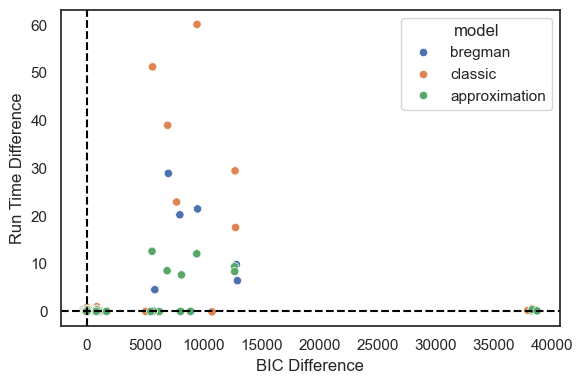

In [81]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=compare, x="bic_diff", y="runtime_diff", hue="model")
plt.axvline(0.1, color='black', linestyle='--')
plt.axhline(0.1, color='black', linestyle='--')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel("BIC Difference")
plt.ylabel("Run Time Difference")

plt.tight_layout()
plt.savefig("plots/models_performance_comparison.pdf")
plt.show()

In [23]:
# Two Layer Model Plots
for name, model in two_layer_models.items():
    model.plot(figsize=4, name=f"tl_{name}", show_title=False, save=True, show=False)

In [24]:
# One Shot Model Plots
for name, model in one_shot_models.items():
    model.plot(figsize=4, name=f"os_{name}", show_title=False, save=True, show=False)

In [78]:
def plot_performance(df, value='bic_score', save=False, ylabel=None):
    for action_type in df["action_type"].unique():
        print(action_type)
        # Filter and set index
        df_filtered = df[df["action_type"] == action_type]
        #df_filtered = df_filtered.set_index("short_name").sort_index()
        names = df_filtered['short_name']
        x = np.arange(len(names))
        width = 0.35

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.bar(x - width / 2, df_filtered[f'{value}_tl'], width,
               label='Two-Layer')
        ax.bar(x + width / 2, df_filtered[f'{value}_os'], width, label='One-shot')

        min_val = df_filtered[[f'{value}_tl', f'{value}_os']].min().min()
        max_val = df_filtered[[f'{value}_tl', f'{value}_os']].max().max()
        ax.set_ylim(0.95 * min_val if min_val > 0 else 1.05 * min_val,
                    1.05 * max_val if max_val > 0 else 0.95 * max_val)

        ax.set_xticks(x)
        ax.set_xticklabels(names, rotation=60)
        if ylabel:
            ax.set_ylabel(ylabel)
        ax.legend(loc="upper right")
        plt.tight_layout()
        if save:
            plt.savefig(f"plots/perf_{value}_{action_type}.pdf")
        plt.show()

freekick


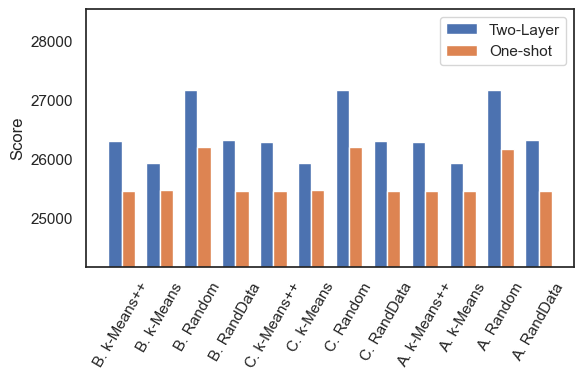

dribble


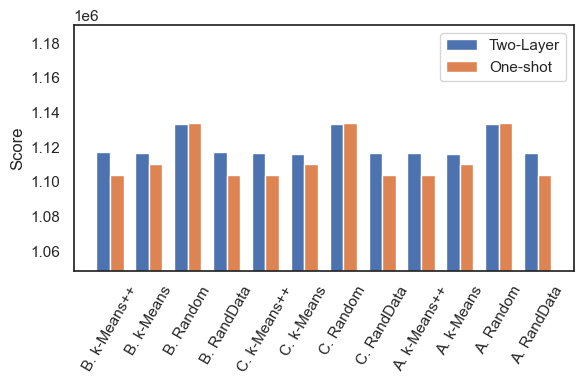

corner


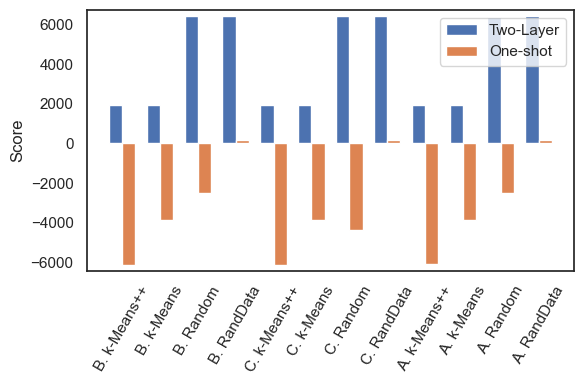

pass


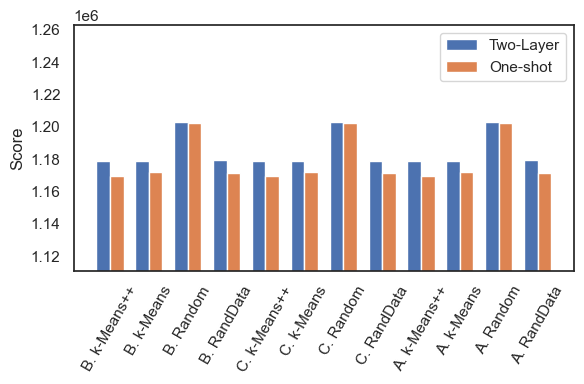

cross


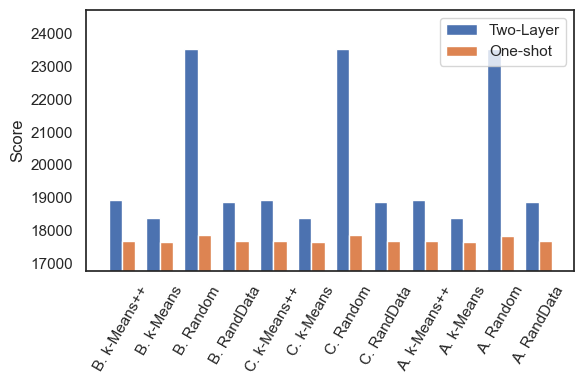

throw_in


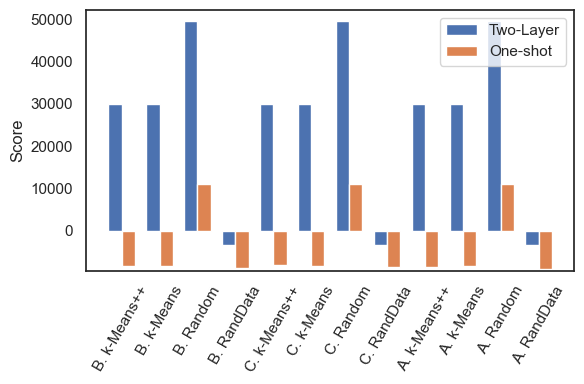

goalkick


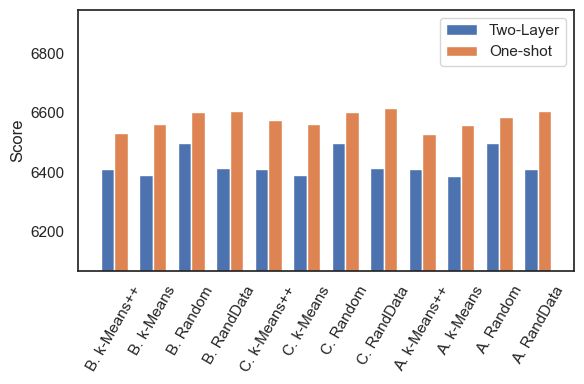

clearance


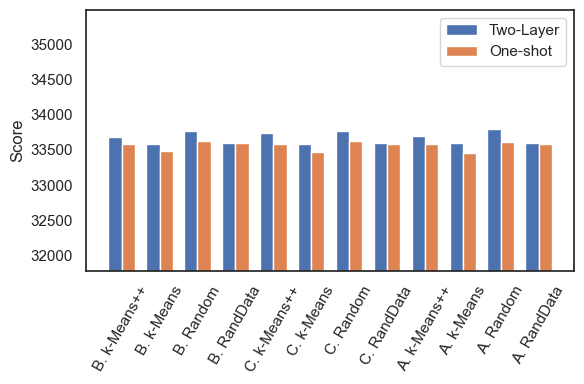

keeper_action


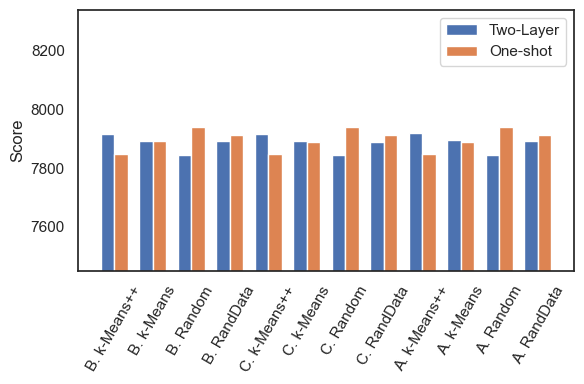

shot


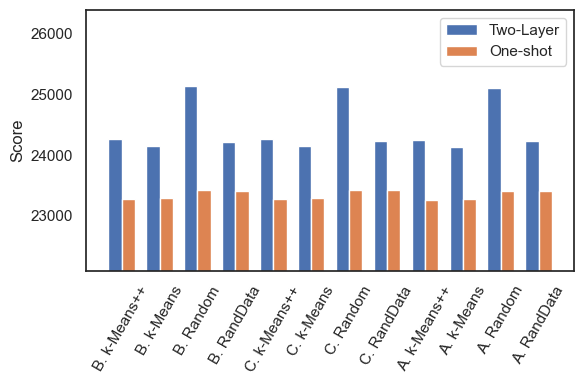

In [79]:
plot_performance(compare, 'bic_score', True, 'Score')

freekick


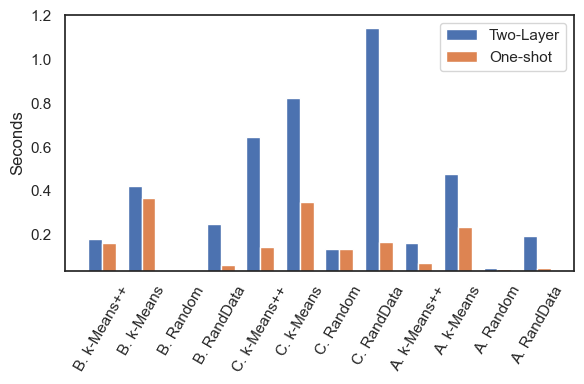

dribble


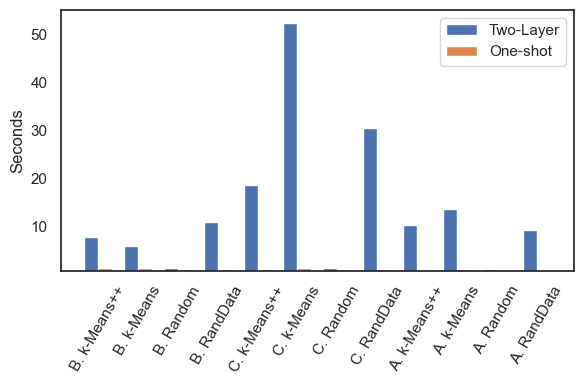

corner


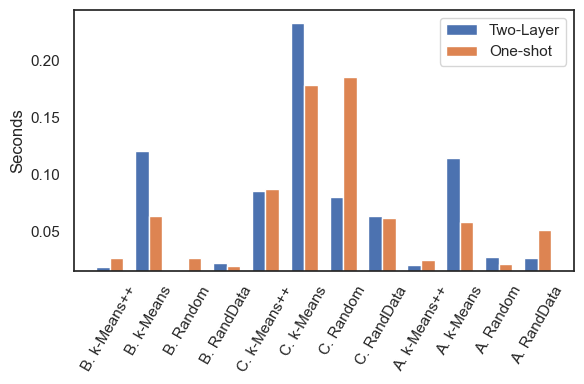

pass


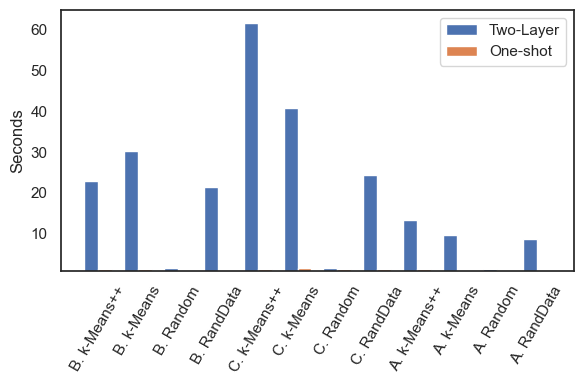

cross


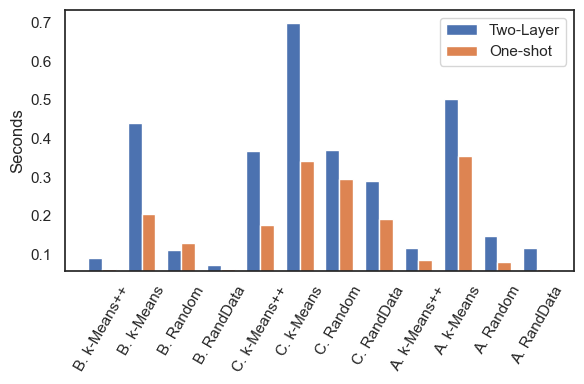

throw_in


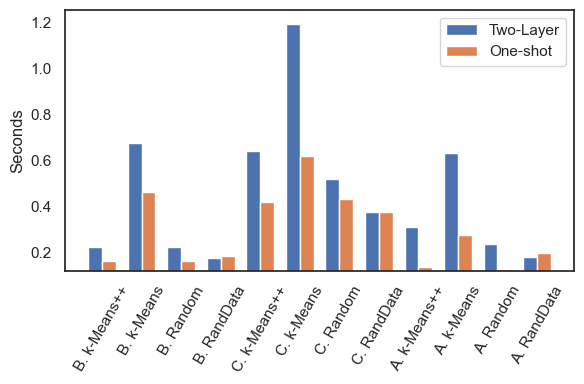

goalkick


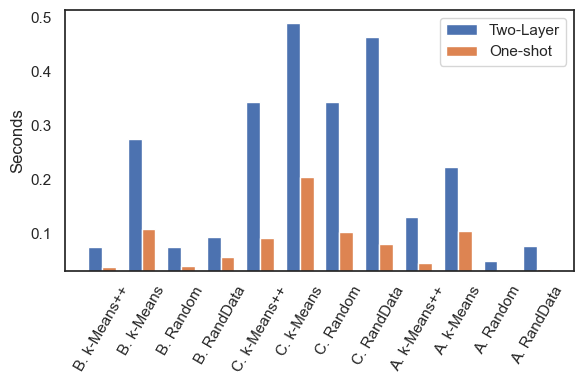

clearance


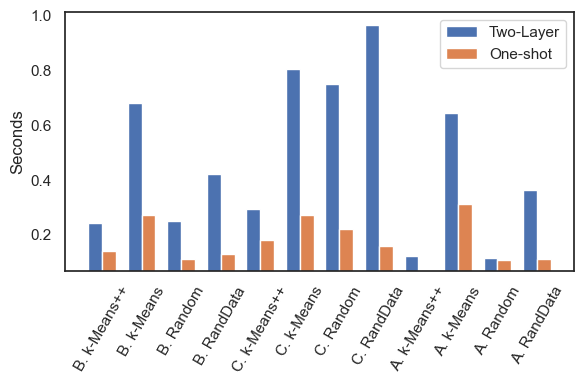

keeper_action


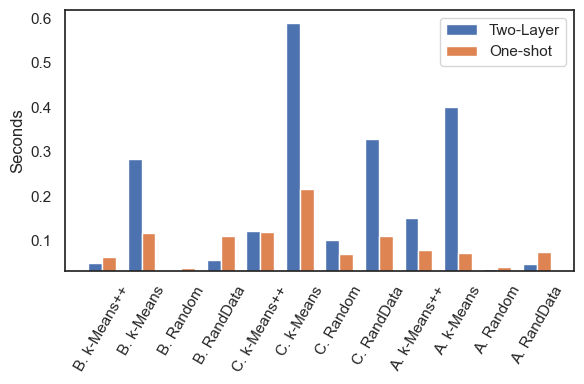

shot


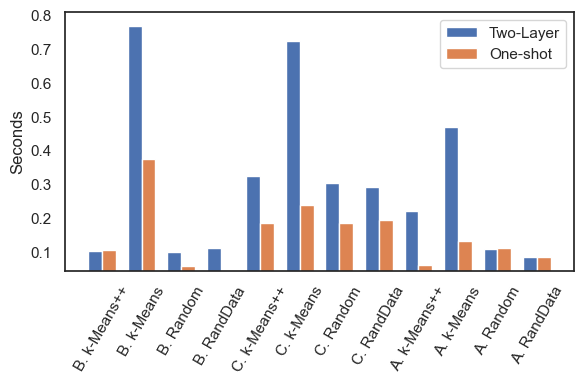

In [80]:
plot_performance(compare, 'running_time', True, 'Seconds')